# Tutorial Part ??: Training a Normalizing Flow on QM9
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey)


In this tutorial, we will train a Normalizing Flow (NF) on the [QM9 dataset](https://www.nature.com/articles/sdata201422). The dataset comprises 133,885 stable small organic molecules made up of CHNOF atoms. We will try to train a network that is an invertible transformation between a simple base distribution and the distribution of molecules in QM9.  One of the key advantages of normalizing flows is that they can be constructed to efficiently sample from a distribution (generative modeling) and do probability density calculations (exactly compute log-likelihoods), whereas other models make tradeoffs between the two or can only approximate probability densities.

NFs are useful whenever we need a probabilistic model with one or both of these capabilities. Note that because NFs are completely invertible, there is no "latent space" in the sense used when referring to generative adversarial networks or variational autoencoders. For more on NFs, we refer to this [review paper](https://arxiv.org/pdf/1912.02762.pdf).


To encode the QM9 dataset, we'll make use of the SELFIES representation, which is a 100% robust molecular string representation. For details about SELFIES, see the [GitHub repo](https://github.com/aspuru-guzik-group/selfies) and the associated [paper](https://arxiv.org/abs/1905.13741).


## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/23_Training_a_Normalizing_Flow_on_QM9.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  20173      0 --:--:-- --:--:-- --:--:-- 20290


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [3]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 399kB 2.9MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20200911162648-cp36-none-any.whl size=493299 sha256=cdf5a714b87d65ac7abe1d14f48623021f43bd32eee6d650334da877a42e8a24
  Stored in directory: /root/.cache/pip/wheels/0c/c2/a9/335ada2de0863f6bb163d2e29bb348b97670a30c91e65ca1d6
Successfully built deepchem


'2.4.0-rc1.dev'

Install the SELFIES library to translate SMILES strings.

In [4]:
!git clone https://github.com/aspuru-guzik-group/selfies.git
%cd selfies
!pip install .
%cd ..

Cloning into 'selfies'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2026 (delta 90), reused 85 (delta 43), pack-reused 1869
Receiving objects: 100% (2026/2026), 12.38 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
/content/selfies
Processing /content/selfies
  Created wheel for selfies: filename=selfies-1.0.1-cp36-none-any.whl size=27081 sha256=e1b9badcc8d339a15c4ddca2b6f45cb3c4779dcc2308766c97e25d12aa45de2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lsp7cwll/wheels/d0/8b/6e/8a44d44da67fdb190acc4f94129ff1428fc623ff9ad9a7abed
Successfully built selfies
/content


In [1]:
# # May be necessary to import modules
# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.molnet import load_tox21

import rdkit

import selfies as sf

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

First, let's get a dataset of 2000 small organic molecules from the QM9 dataset. We'll then convert the molecules to SELFIES, one-hot encode them, and dequantize the inputs so they can be processed by a normalizing flow.

In [6]:
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
cwd = os.getcwd()
dc.utils.download_url(url=url, dest_dir=cwd)

In [7]:
df = pd.read_csv('qm9.csv', usecols=['smiles'])
smiles_list = np.asanyarray(df.smiles)  # Full ~130K QM9 molecules
data = df[['smiles']].sample(2000, random_state=42)

In [8]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

data['selfies'] = data['smiles'].apply(preprocess_smiles)

To convert SELFIES to a one-hot encoded representation, we need to construct an `alphabet` of all the characters that occur in the list of SELFIES strings. We also have to know what the longest SELFIES string is, so that all the shorter SELFIES can be padded with `'[nop]'` to be equal length.

In [9]:
selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
selfies_alphabet = list(sorted(selfies_alphabet))
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)

`selfies` has a handy utility function to translate SELFIES strings into one-hot encoded vectors.

In [10]:
onehots = sf.multiple_selfies_to_hot(selfies_list, largest_selfie_len, selfies_alphabet)

Next, we "dequantize" the inputs by adding random noise from the interval `[0, 1)` to every input in the encodings. This allows the normalizing flow to operate on continuous inputs (rather than discrete), and the original inputs can easily be recovered by applying a floor function.

In [11]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

The dequantized data is ready to be processed as a DeepChem dataset.

In [12]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
dim = len(ds.X[0])  # length of one-hot encoded vectors
ds.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(2000, 567)

Next we'll set up the normalizing flow model. The base distribution is a multivariate Normal distribution. The `permutation` layer permutes the dimensions of the input so that the normalizing flow layers will operate along multiple dimensions of the inputs.

In [13]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))),
                                  tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

For this simple example, we'll set up a flow of repeating [Masked Autoregressive Flow](https://arxiv.org/abs/1705.07057) layers. The autoregressive property is enforced by using the [Masked Autoencoder for Distribution Estimation](https://arxiv.org/abs/1502.03509) architecture. The layers of the flow are a bijector, an invertible mapping between the base and target distributions. Batch Normalization layers can be added for additional stability in training, but may have strange effects on the outputs and require some input reshaping to work properly. Increasing `num_layers` and `hidden_units` can make more expressive flows capable of modeling more complex target distributions.

In [14]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2, hidden_units=[512, 512], activation='relu')

for i in range(num_layers):
    flow_layers.append(        
        tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)
    )
    
    flow_layers.append(tfb.Permute(permutation=permutation))
    
#     if (i + 1) % int(2) == 0:
#         flow_layers.append(tfb.BatchNormalization())

We can draw samples from the untrained distribution, but for now they don't have any relation to the QM9 dataset distribution.

In [15]:
nf = NormalizingFlow(base_distribution=base_dist,
                    flow_layers=flow_layers)
samples = nf.flow.sample(5)

In [16]:
# Increase the number of epochs for better performance
max_epochs = int(1e2)  # maximum number of epochs of the training
opt = Adam(learning_rate=1e-4)  # optimizer

In [17]:
nfm = NormalizingFlowModel(nf, optimizer=opt, batch_size=ds.X.shape[0])

Now to train the model! We'll try to minimize the negative log likelihood loss, which measures the likelihood that generated samples are drawn from the target distribution, i.e. as we train the model, it should get better at modeling the target distribution and it will generate samples that look like molecules from the QM9 dataset. 

In [18]:
losses = []

In [19]:
%%time
for epoch in range(max_epochs):  # max_epochs
    loss = nfm.fit(ds, nb_epoch=1)
    losses.append(loss)

CPU times: user 27min 59s, sys: 16.3 s, total: 28min 15s
Wall time: 14min 33s


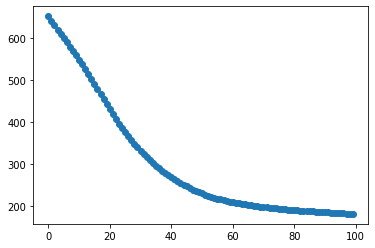

In [20]:
plt.scatter(range(len(losses)), losses)

Not too bad! The normalizing flow is a pretty good mapping between the multivariate Gaussian and the target distribution. We can now use `nfm.flow.sample()` to generate new QM9-like molecules and `nfm.flow.log_prob()` to evaluate the likelihood that a molecule was drawn from the underlying distribution.

In [21]:
generated_samples = nfm.flow.sample(50)  # generative modeling
log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

Now we transform the generated samples back into SELFIES. We have to quantize the outputs and add padding characters to any one-hot encoding vector that has all zeros.

In [23]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(largest_selfie_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      mol[len(selfies_alphabet) * (i+1) - 1] = 1

`selfies` has another utility function to translate one-hot encoded representations back to SELFIES strings.

In [24]:
mols = sf.multiple_hot_to_selfies(mols_list, largest_selfie_len, selfies_alphabet)

We can use RDKit to find valid generated molecules. Some have unphysical valencies and should be discarded.

In [35]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies = []
for idx, selfies in enumerate(mols):
    if Chem.MolFromSmiles(sf.decoder(mols[idx])) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
print('%.2f' % (valid_count / len(mols)),  '% of generated samples are valid molecules.')

0.40 % of generated samples are valid molecules.


Let's take a look at some of the generated molecules! We'll borrow some helper functions from the [Modeling Solubility](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/03_Modeling_Solubility.ipynb) tutorial to display molecules with RDKit.

In [36]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]
qm9_mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

In [26]:
from rdkit.Chem import Draw
from IPython.display import Image, display

def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

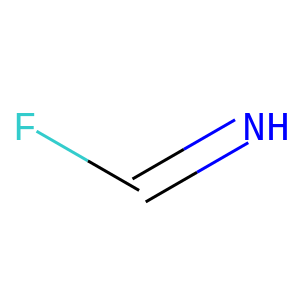

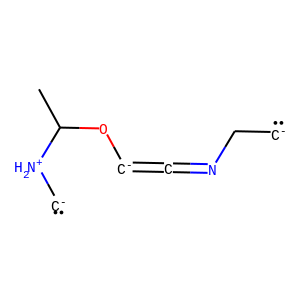

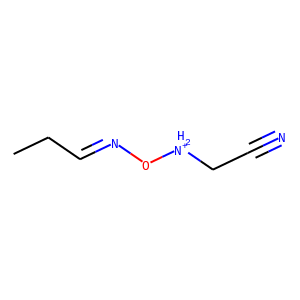

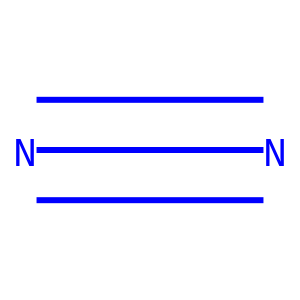

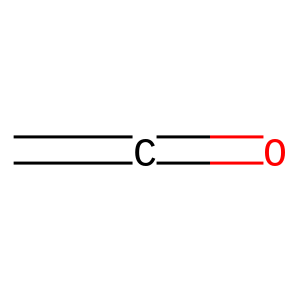

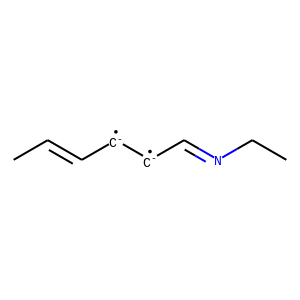

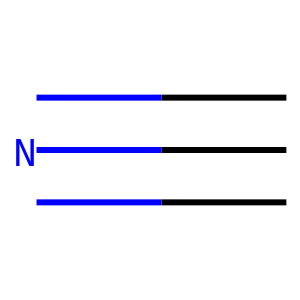

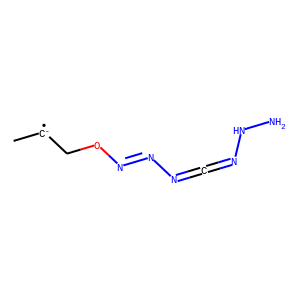

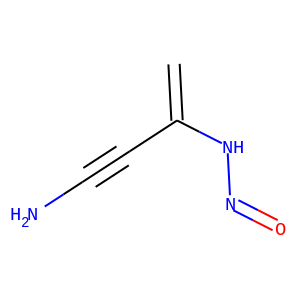

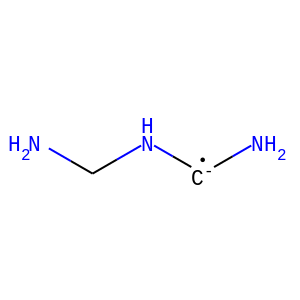

In [39]:
display_mols = []
for i in range(10):
  display_mols.append(gen_mols[i])

display_images(mols_to_pngs(display_mols))

Finally, we can compare generated molecules with QM9 via a [similarity search](https://medium.com/gsi-technology/rdkit-for-newbies-3697e617521f) with Tanimoto similarity. This gives an indication of how "original" the generated samples are, versus simply producing samples that are extremely similar to existing molecules in QM9.

In [40]:
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol
from rdkit.DataStructs import FingerprintSimilarity
from IPython.display import display

def tanimoto_similarity(database_mols, query_mol):
    """Compare generated molecules to database by Tanimoto similarity."""
    # convert Mol to datastructure type
    fps = [FingerprintMol(m) for m in database_mols]
    
    # set a query molecule to compare against database
    query = FingerprintMol(query_mol)
    
    similarities = []
    
    # loop through to find Tanimoto similarity
    for idx, f in enumerate(fps):
        # tuple: (idx, similarity)
        similarities.append((idx, FingerprintSimilarity(query, f)))
    
    # sort sim using the similarities
    similarities.sort(key=lambda x:x[1], reverse=True)
    
    return similarities

We'll consider our generated molecules and look at the top 3 most similar molecules from QM9 by Tanimoto similarity. Here's an example where the Tanimoto similarity scores are low! There are no molecules in QM9 that are very similar to our generated sample. This might be interesting, or it might mean that the generated molecule is unrealistic.

In [52]:
# change the second argument to compare different generated molecules to QM9
tanimoto_scores = tanimoto_similarity(qm9_mols, gen_mols[1])
similar_mols = []

0.333
0.308
0.267


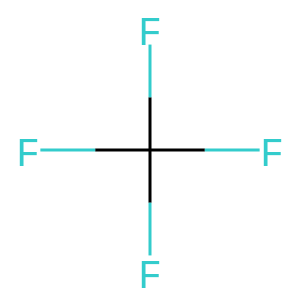

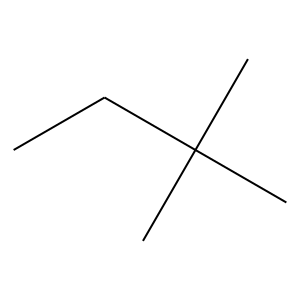

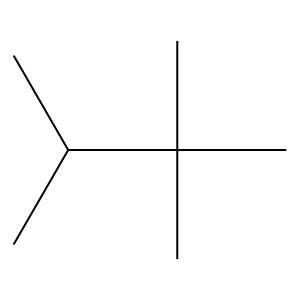

In [42]:
for idx, ts in tanimoto_scores[:3]:
    print(round(ts, 3))
    similar_mols.append(qm9_mols[idx])

display_images(mols_to_pngs(similar_mols, 'qm9_mol'))

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!